VGG 19 con input 600x400 - NO Regularization

In [ ]:
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras

In [ ]:
#This to allow reproducibilty
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
#Access to GoogleDrive and set dataframe directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/My Drive/DeepLearning/Image Classification/MaskDataset"

In [ ]:
#Load dataset and "make" it categorical, and so following path data/training/class_1/img_1, img_2 ...
with open(os.path.join(dataset_dir,"train_gt.json")) as train_label:
    train_dict = json.load(train_label)

dataframe = pd.DataFrame(train_dict.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe["class"] = dataframe["class"].astype(str)                             #cast "class" to string
dataframe = dataframe.sample(frac=1).reset_index(drop=True)                     #shuffle dataframe (Keras performs it after splitting so having images ordered by class is ineffective)

In [ ]:
#Data Augmentation performed on Training set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input 


img_h = 600
img_w = 400
#This should allow us to make classes detailed with a description, but do no work :(
class_detailed = ['NO_PERSON', 
                  'ALL_PEOPLE', 
                  'SOMEONE']
training_dir = os.path.join(dataset_dir,'training')

#No zoom, rotating and anything that let image "lose information" since those transformations can modify image class
train_data_gen = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1/255.,
                                    validation_split=0.10,
                                    preprocessing_function = preprocess_input)

train_set_gen = train_data_gen.flow_from_dataframe(dataframe,
                                                   training_dir,
                                                   batch_size=4,
                                                   target_size=(img_h, img_w),
                                                   #classes=class_detailed,
                                                   class_mode='categorical',
                                                   subset='training',
                                                   shuffle=True,
                                                   seed=SEED)

#Operating in this way Augmentation is performed only on Training data (Validation set has fresh generator)
validation_data_gen = ImageDataGenerator(rescale=1/255.,
                                         validation_split=0.10,
                                         preprocessing_function=preprocess_input)


valid_set_gen = validation_data_gen.flow_from_dataframe(dataframe,
                                                         training_dir,
                                                         batch_size=4,
                                                         target_size=(img_h, img_w),
                                                         #classes=class_detailed,
                                                         class_mode='categorical',  
                                                         subset='validation',
                                                         shuffle=True,
                                                         seed=SEED)


count = 0
for image in valid_set_gen.filenames:
  for image2 in train_set_gen.filenames:
    if(image == image2):
      count+=1
print("Common image among sets: " + str(count))         #checking for disjointness of validation and training set

count_0 = 0
count_1 = 0
count_2 = 0
for classes in valid_set_gen.classes:
  if classes == 0:
    count_0 += 1
  if classes == 1:
    count_1 += 1
  if classes == 2:
    count_2 += 1
print("Image of class 0 #" + str(count_0))
print("Image of class 1 #" + str(count_1))
print("Image of class 2 #" + str(count_2))               #checking image distribution w.r.t classes among validation set 

Found 5053 validated image filenames belonging to 3 classes.
Found 561 validated image filenames belonging to 3 classes.
Common image among sets: 0


In [ ]:
#Now let's shape train, validation set.
num_classes = 3

#TRAINING
training_set = tf.data.Dataset.from_generator(lambda: train_set_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h,img_w,3], [None, num_classes]))
training_set = training_set.repeat()

#VALIDATION
validation_set = tf.data.Dataset.from_generator(lambda: valid_set_gen,
                                                output_types=(tf.float32, tf.float32),
                                                output_shapes=([None, img_h,img_w,3], [None, num_classes]))
validation_set = validation_set.repeat()

[]

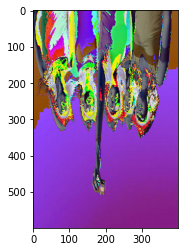

In [ ]:
#This allow us to see the images fed to our NN
import matplotlib.pyplot as plt
%matplotlib inline

iterator = iter(training_set)
augmented_img, target = next(iterator)

augmented_img = np.array(augmented_img[0])
augmented_img = augmented_img * 255

plt.imshow(np.uint8(augmented_img))
plt.plot()

In [ ]:
# Load VGG19
pre_trained_model = VGG19(input_shape=(img_h,img_w,3), include_top=False, weights="imagenet")

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 100, 128)     0     

In [ ]:
# Create CNN model
finetuning = True

if finetuning:
    freeze_until = 18 # layer from which we want to fine-tune
    
    for layer in pre_trained_model.layers[:freeze_until]:
        layer.trainable = False
else:
    pre_trained_model.trainable = False

#Add CNN to model
model = tf.keras.Sequential()
model.add(pre_trained_model)

#Add FCNN part (CNN top)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 18, 12, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 110592)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               28311808  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 48,352,835
Trainable params: 35,407,875
Non-trainable params: 12,944,960
_________________________________________________________________


In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
callbacks = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks.append(es_callback)

In [ ]:
history = model.fit(x=training_set,
                    epochs=100,
                    steps_per_epoch=len(train_set_gen),
                    validation_data=validation_set,
                    validation_steps=len(valid_set_gen),
                    callbacks=callbacks)

Epoch 1/100
1264/1264 [==============================] - 1625s 1s/step - loss: 0.7374 - accuracy: 0.6463 - val_loss: 0.5705 - val_accuracy: 0.6916
Epoch 2/100
1264/1264 [==============================] - 169s 133ms/step - loss: 0.5085 - accuracy: 0.7578 - val_loss: 0.5496 - val_accuracy: 0.7326
Epoch 3/100
1264/1264 [==============================] - 167s 132ms/step - loss: 0.4347 - accuracy: 0.8011 - val_loss: 0.4971 - val_accuracy: 0.7897
Epoch 4/100
1264/1264 [==============================] - 168s 133ms/step - loss: 0.3813 - accuracy: 0.8344 - val_loss: 0.4453 - val_accuracy: 0.7932
Epoch 5/100
1264/1264 [==============================] - 167s 132ms/step - loss: 0.3347 - accuracy: 0.8532 - val_loss: 0.4352 - val_accuracy: 0.7986
Epoch 6/100
1264/1264 [==============================] - 167s 132ms/step - loss: 0.3077 - accuracy: 0.8668 - val_loss: 0.4122 - val_accuracy: 0.8271
Epoch 7/100
1264/1264 [==============================] - 168s 133ms/step - loss: 0.2812 - accuracy: 0.8805 -

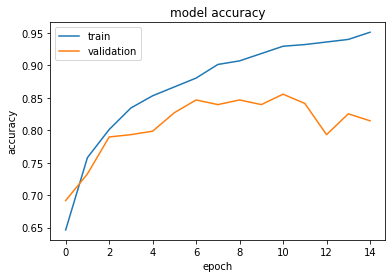

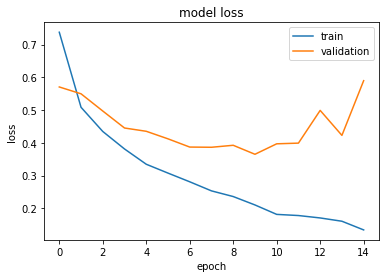

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
from PIL import Image

dataset_dir_test = os.path.join(dataset_dir,"test") #Path di questo tipo /content/drive/My Drive/DeepLearning/Image Classification/MaskDataset/test
image_filenames = next(os.walk(dataset_dir_test))[2]

results = {}
for image_name in image_filenames:

  img = Image.open(os.path.join(dataset_dir_test, image_name)).convert('RGB')
  img = img.resize((img_h, img_w))
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, 0) 
  img_array = preprocess_input(img_array)

  prediction = model.predict(img_array)
  results[image_name] = np.argmax(np.matrix(prediction))

create_csv(results, os.path.join(dataset_dir,"Results/Comune"))